In [19]:
!pip install xskillscore

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 351.6 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 kB 4.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 24.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 33.8 MB/s eta 0:00:00:00:0100:01


In [20]:
import os
import datetime as dt  # Python standard library datetime  module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV
from eofs.xarray import Eof
import utils
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import transforms
from xskillscore import rmse

In [2]:
test_Y = xr.open_dataset('outputs_ssp245.nc').compute()
test_Y

<xarray.Dataset>
Dimensions:                    (lat: 96, lon: 144, time: 86, member: 3)
Coordinates:
  * lat                        (lat) float64 -90.0 -88.11 -86.21 ... 88.11 90.0
  * lon                        (lon) float64 0.0 2.5 5.0 ... 352.5 355.0 357.5
  * time                       (time) int64 2015 2016 2017 ... 2098 2099 2100
    quantile                   float64 0.9
  * member                     (member) int64 1 2 3
Data variables:
    diurnal_temperature_range  (member, time, lat, lon) float32 0.1953 ... -0...
    tas                        (member, time, lat, lon) float32 1.601 ... 5.677
    pr                         (member, time, lat, lon) float32 9.877e-09 ......
    pr90                       (member, time, lat, lon) float64 -1.104e-07 .....

In [3]:
#extract each actual y variables
tas_truth = test_Y["tas"].mean('member')
pr_truth = test_Y["pr"].mean('member') * 86400
pr90_truth = test_Y["pr90"].mean('member') * 86400
dtr_truth = test_Y["diurnal_temperature_range"].mean('member')

In [6]:
#extract the predicted data
#extract the predicted data
xr_output = xr.open_dataset('xr_output_xgboost.nc').compute()
xr_output

<xarray.Dataset>
Dimensions:                    (time: 86, lat: 96, lon: 144)
Coordinates:
  * time                       (time) int64 2015 2016 2017 ... 2098 2099 2100
  * lat                        (lat) float64 -90.0 -88.11 -86.21 ... 88.11 90.0
  * lon                        (lon) float64 0.0 2.5 5.0 ... 352.5 355.0 357.5
Data variables:
    tas                        (time, lat, lon) float32 1.071 1.026 ... 6.785
    diurnal_temperature_range  (time, lat, lon) float32 -0.04081 ... -0.5589
    pr                         (time, lat, lon) float32 0.003638 ... 0.09024
    pr90                       (time, lat, lon) float32 -0.001195 ... 0.4164

In [5]:
def global_mean(ds):
    if 'lat' not in ds.coords:
        ds_ = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
    else:
        ds_ = ds
    weights = np.cos(np.deg2rad(ds_.lat))
    return ds_.weighted(weights).mean(['lat', 'lon'])
def get_rmse(a,b):
    return np.sqrt(np.mean((a-b)**2))
def rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data.mean()

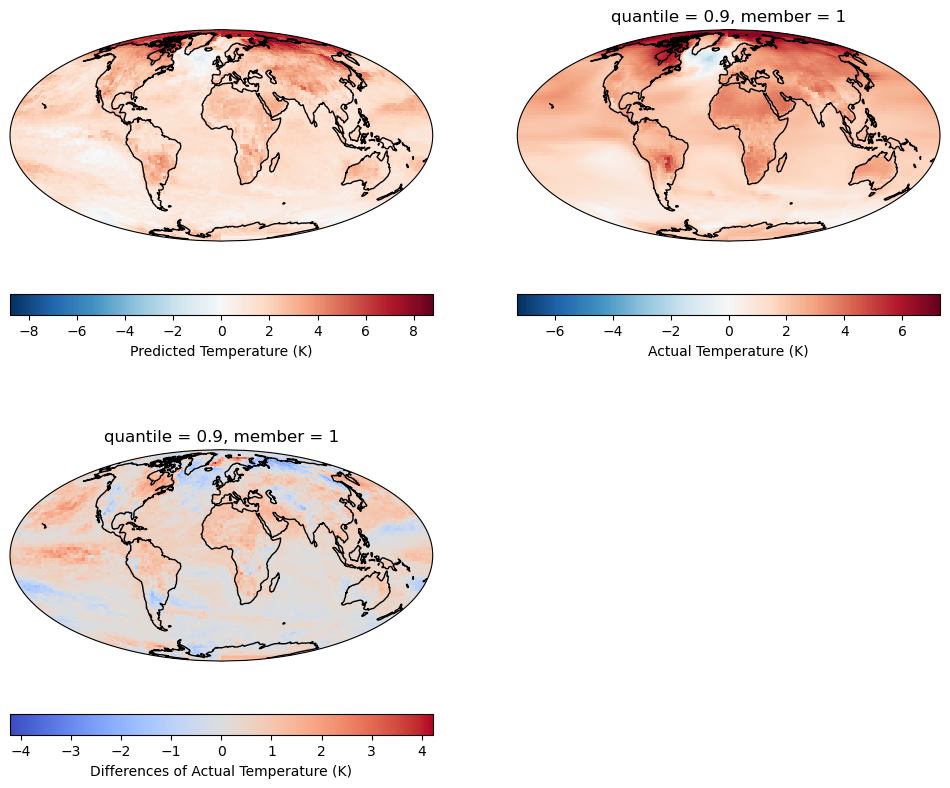

In [17]:
#getting plot for the predicted temperature
fig = plt.figure(figsize=(12, 10))
plt.subplot(221, projection=ccrs.Mollweide())
xr_output['tas'].sel(time=slice(2080, 2100)).mean(['time']).plot(transform=ccrs.PlateCarree(),
                                                                cbar_kwargs={"label":"Predicted Temperature (K)", "orientation":'horizontal'})
plt.gca().coastlines()
#getting plot for the actual temperature
plt.subplot(222,projection=ccrs.Mollweide())
test_Y["tas"].sel(time=slice(2080,2100),member=1).mean(['time']).plot(transform=ccrs.PlateCarree(),
                                                                     cbar_kwargs={"label":"Actual Temperature (K)", "orientation":'horizontal'})
plt.gca().coastlines()
#getting plot for the differences
diff_tas = test_Y["tas"].sel(time=slice(2080,2100),member=1).mean(['time']) - xr_output['tas'].sel(time=slice(2080, 2100)).mean(['time'])
plt.subplot(223, projection=ccrs.Mollweide())
diff_tas.plot(cmap='coolwarm', transform=ccrs.PlateCarree(),cbar_kwargs={"label":"Differences of Actual Temperature (K)", "orientation":'horizontal'})
plt.gca().coastlines()

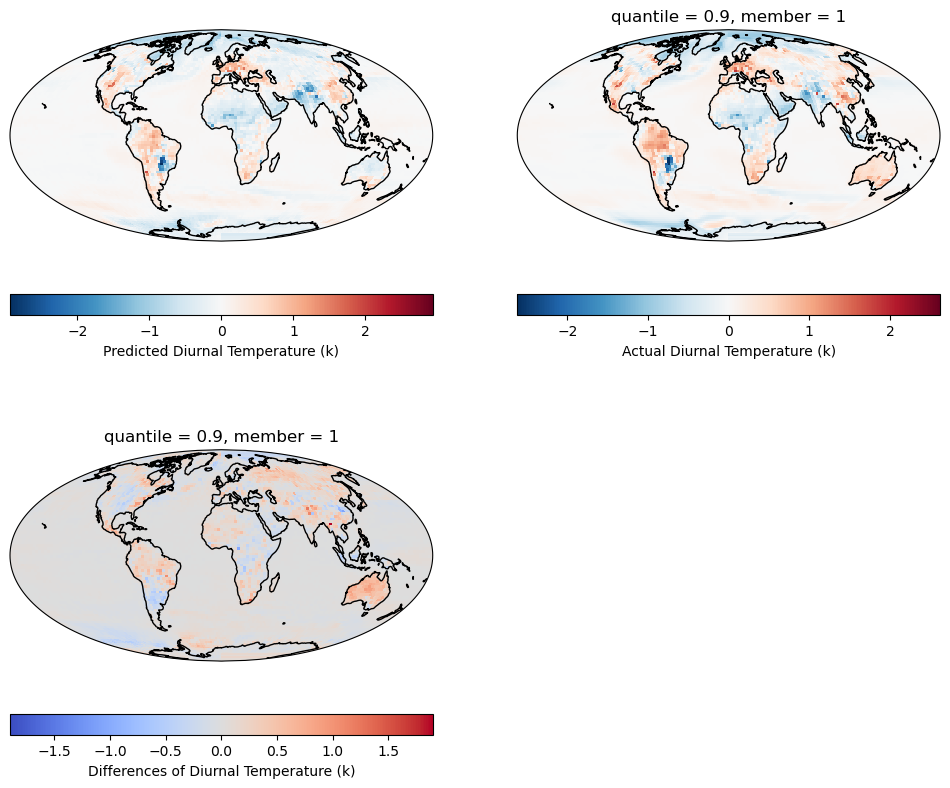

In [16]:
#getting plot for the predicted dtr
fig = plt.figure(figsize=(12, 10))
plt.subplot(221, projection=ccrs.Mollweide())
xr_output['diurnal_temperature_range'].sel(time=slice(2080, 2100)).mean(['time']).plot(transform=ccrs.PlateCarree(),
                                                                cbar_kwargs={"label":"Predicted Diurnal Temperature (k)", "orientation":'horizontal'})
plt.gca().coastlines()

#getting plot for the actual dtr

plt.subplot(222, projection=ccrs.Mollweide())
test_Y["diurnal_temperature_range"].sel(time=slice(2080,2100),member=1).mean(['time']).plot(transform=ccrs.PlateCarree(),
                                                                     cbar_kwargs={"label":"Actual Diurnal Temperature (k)", "orientation":'horizontal'})
plt.gca().coastlines()

#getting the abs differences between actual and predicted dtr
diff_dtr = test_Y["diurnal_temperature_range"].sel(time=slice(2080,2100),member=1).mean(['time']) - xr_output["diurnal_temperature_range"].sel(time=slice(2080, 2100)).mean(['time'])

plt.subplot(223, projection=ccrs.Mollweide())
diff_dtr.plot(cmap='coolwarm', transform=ccrs.PlateCarree(),cbar_kwargs={"label":"Differences of Diurnal Temperature (k)", "orientation":'horizontal'})
plt.gca().coastlines()

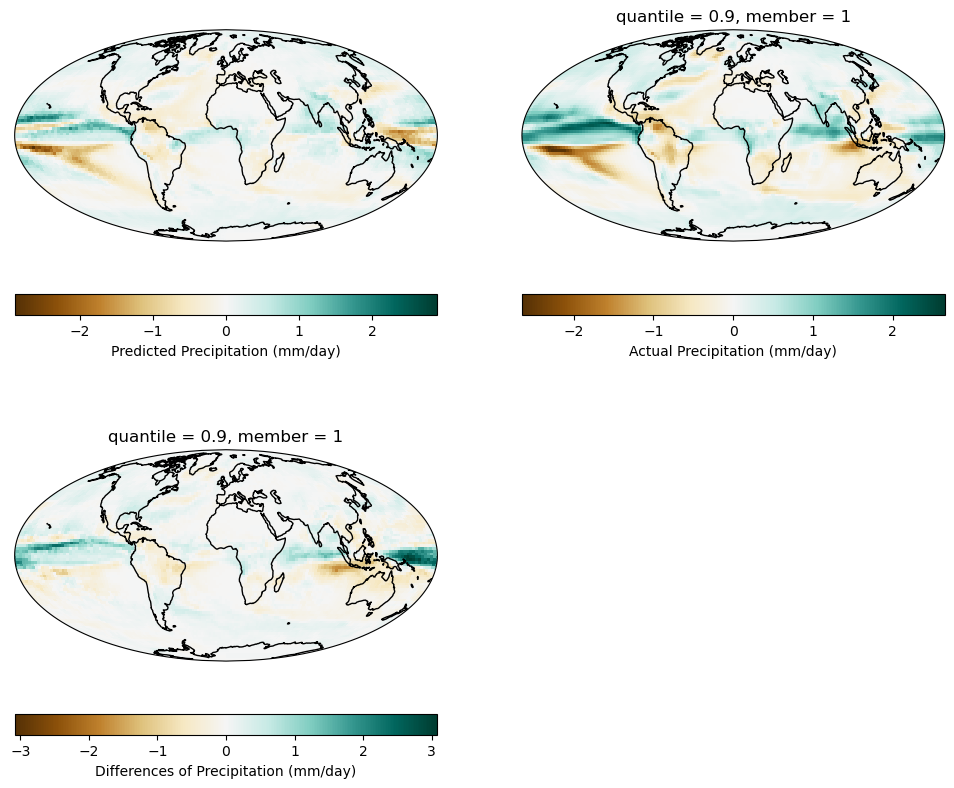

In [15]:
#getting plot for the predicted pr
fig = plt.figure(figsize=(12, 10))
plt.subplot(221, projection=ccrs.Mollweide())
xr_output['pr'].sel(time=slice(2080, 2100)).mean(['time']).plot(cmap="BrBG", transform=ccrs.PlateCarree(),
                                                                cbar_kwargs={"label":"Predicted Precipitation (mm/day)", "orientation":'horizontal'})
plt.gca().coastlines()

#getting plot for the actual pr

plt.subplot(222, projection=ccrs.Mollweide())
test_Y['pr'].sel(time=slice(2080, 2100),member=1).mean(['time']).plot(cmap="BrBG", transform=ccrs.PlateCarree(),
                                                                cbar_kwargs={"label":"Actual Precipitation (mm/day)", "orientation":'horizontal'})
plt.gca().coastlines()

#getting the abs difference between actual and predicted pr
diff_pr = test_Y["pr"].sel(time=slice(2080,2100),member=1).mean(['time']) - xr_output["pr"].sel(time=slice(2080, 2100)).mean(['time'])

plt.subplot(223, projection=ccrs.Mollweide())
diff_pr.plot(cmap='BrBG', transform=ccrs.PlateCarree(),cbar_kwargs={"label":"Differences of Precipitation (mm/day)", "orientation":'horizontal'})
plt.gca().coastlines()

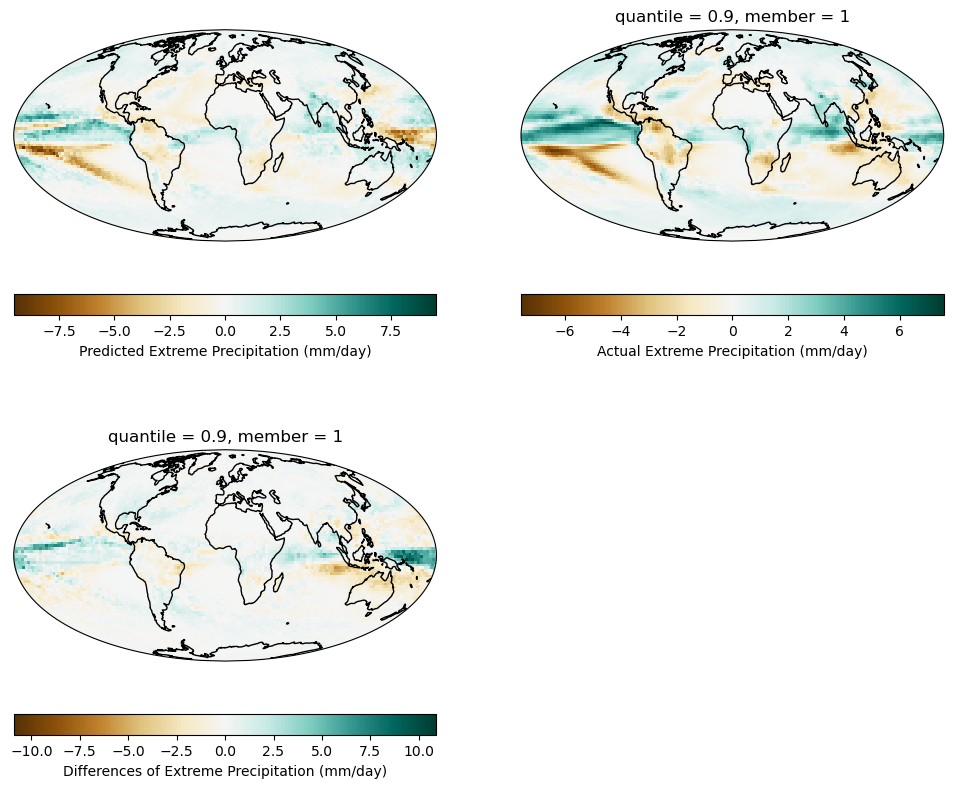

In [14]:
# getting plot for the predicted pr90
fig = plt.figure(figsize=(12, 10))
plt.subplot(221, projection=ccrs.Mollweide())
xr_output['pr90'].sel(time=slice(2080, 2100)).mean(['time']).plot(cmap="BrBG",transform=ccrs.PlateCarree(),
                                                                cbar_kwargs={"label":"Predicted Extreme Precipitation (mm/day)", "orientation":'horizontal'})
plt.gca().coastlines()

#getting plot for the actual pr90

plt.subplot(222, projection=ccrs.Mollweide())
test_Y['pr90'].sel(time=slice(2080, 2100),member=1).mean(['time']).plot(cmap="BrBG",transform=ccrs.PlateCarree(),
                                                                cbar_kwargs={"label":"Actual Extreme Precipitation (mm/day)", "orientation":'horizontal'})
plt.gca().coastlines()

#getting the abs difference between actual and predicted pr90
diff_pr = test_Y["pr90"].sel(time=slice(2080,2100),member=1).mean(['time']) - xr_output["pr90"].sel(time=slice(2080, 2100)).mean(['time'])

plt.subplot(223, projection=ccrs.Mollweide())
diff_pr.plot(cmap='BrBG', transform=ccrs.PlateCarree(),cbar_kwargs={"label":"Differences of Extreme Precipitation (mm/day)", "orientation":'horizontal'})
plt.gca().coastlines()

In [11]:
#calculate the rmse between actual y and predict y for tas
print('RMSE score of tas')
print(f"RMSE of 2050: {rmse(tas_truth[35],xr_output['tas'][35])}")
print(f"RMSE of 2100: {rmse(tas_truth[85],xr_output['tas'][85])}")
print(f"RMSE of 2045-2054: {rmse(tas_truth[30:40], xr_output['tas'][30:40])}")
print(f"RMSE of 2090-2100: {rmse(tas_truth[75:], xr_output['tas'][75:])}")
print(f"RMSE: {rmse(tas_truth[35:], xr_output['tas'][35:])}")
print("\n")

#calculate the rmse between actual y and predicted y for dtr
print('RMSE score of dtr')
print(f"RMSE of 2050: {rmse(dtr_truth[35],xr_output['diurnal_temperature_range'][35])}")
print(f"RMSE of 2100: {rmse(dtr_truth[85],xr_output['diurnal_temperature_range'][85])}")
print(f"RMSE of 2045-2054: {rmse(dtr_truth[30:40], xr_output['diurnal_temperature_range'][30:40])}")
print(f"RMSE of 2090-2100: {rmse(dtr_truth[75:], xr_output['diurnal_temperature_range'][75:])}")
print(f"RMSE: {rmse(dtr_truth[35:], xr_output['diurnal_temperature_range'][35:])}")
print("\n")

#calculate the rmse between actual y and predicted y for pr
print('RMSE score of pr')
print(f"RMSE of 2050: {rmse(pr_truth[35],xr_output['pr'][35])}")
print(f"RMSE of 2100: {rmse(pr_truth[85],xr_output['pr'][85])}")
print(f"RMSE of 2045-2054: {rmse(pr_truth[30:40], xr_output['pr'][30:40])}")
print(f"RMSE of 2090-2100: {rmse(pr_truth[75:], xr_output['pr'][75:])}")
print(f"RMSE: {rmse(pr_truth[35:], xr_output['pr'][35:])}")
print("\n")

#calculate the rmse between actual y and predicted y for pr90
print('RMSE score of pr90')
print(f"RMSE of 2050: {rmse(pr90_truth[35],xr_output['pr90'][35])}")
print(f"RMSE of 2100: {rmse(pr90_truth[85],xr_output['pr90'][85])}")
print(f"RMSE of 2045-2054: {rmse(pr90_truth[30:40], xr_output['pr90'][30:40])}")
print(f"RMSE of 2090-2100: {rmse(pr90_truth[75:], xr_output['pr90'][75:])}")
print(f"RMSE: {rmse(pr90_truth[35:], xr_output['pr90'][35:])}")
print("\n")

RMSE score of tas
RMSE of 2050: 0.4828940574014491
RMSE of 2100: 0.7698142936204038
RMSE of 2045-2054: 0.5311567852821562
RMSE of 2090-2100: 0.7496389738277219
RMSE: 0.7177095153064253


RMSE score of dtr
RMSE of 2050: 0.1613808757227576
RMSE of 2100: 0.16984190800743898
RMSE of 2045-2054: 0.1641727345967188
RMSE of 2090-2100: 0.1876704303950217
RMSE: 0.17923427714986945


RMSE score of pr
RMSE of 2050: 0.45157161733717815
RMSE of 2100: 0.681892774343103
RMSE of 2045-2054: 0.5418228934023746
RMSE of 2090-2100: 0.5933584599284152
RMSE: 0.5790836215938765


RMSE score of pr90
RMSE of 2050: 1.5344656294210353
RMSE of 2100: 1.9951812755864209
RMSE of 2045-2054: 1.7330777769013852
RMSE of 2090-2100: 1.7800617887476387
RMSE: 1.7626517270439699




In [12]:
#calculate the rmse for the last 20 years
tas_truth2=tas_truth[-20:].mean(dim="time")
pr_truth2=pr_truth[-20:].mean(dim="time")
pr90_truth2=pr90_truth[-20:].mean(dim="time")
dtr_truth2=dtr_truth[-20:].mean(dim="time")

print(f"RMSE for tas: {get_rmse(tas_truth2, xr_output['tas'][-20:]).data}")
print(f"RMSE for dtr: {get_rmse(dtr_truth2, xr_output['diurnal_temperature_range'][-20:]).data}")
print(f"RMSE for pr: {get_rmse(pr_truth2, xr_output['pr'][-20:]).data}")
print(f"RMSE for pr90: {get_rmse(pr90_truth2, xr_output['pr90'][-20:]).data}")

RMSE for tas: 0.8168920874595642
RMSE for dtr: 0.14119037985801697
RMSE for pr: 0.2635086345750996
RMSE for pr90: 0.8531806934808093


In [13]:
test_Y["pr"] *= 86400
test_Y["pr90"] *= 86400

In [21]:
weights = np.cos(np.deg2rad(test_Y['tas'].lat)).expand_dims(lon=144).assign_coords(lon=test_Y.lon)

In [22]:
#get nrmse for tas
NRMSE_tas = rmse(test_Y.mean('member')['tas'].sel(time=slice(2080, None)).mean('time'), 
                               xr_output['tas'].sel(time=slice(2080, None)).mean('time'),weights=weights)/np.abs(global_mean(test_Y.mean('member')['tas'].sel(time=slice(2080, None)).mean('time')).data)
NRMSE_tas

<xarray.DataArray ()>
array(0.30607731)
Coordinates:
    quantile  float64 0.9

In [23]:
#get nrmse for dtr
NRMSE_dtr = rmse(test_Y.mean('member')["diurnal_temperature_range"].sel(time=slice(2080, None)).mean('time'), 
                               xr_output["diurnal_temperature_range"].sel(time=slice(2080, None)).mean('time'),weights=weights)/np.abs(global_mean(test_Y.mean('member')['diurnal_temperature_range'].sel(time=slice(2080, None)).mean('time')).data)
NRMSE_dtr

<xarray.DataArray ()>
array(12.04714988)
Coordinates:
    quantile  float64 0.9

In [24]:
#get nrmse for pr
NRMSE_pr = rmse(test_Y.mean('member')["pr"].sel(time=slice(2080, None)).mean('time'), 
                               xr_output["pr"].sel(time=slice(2080, None)).mean('time'),weights=weights)/np.abs(global_mean(test_Y.mean('member')["pr"].sel(time=slice(2080, None)).mean('time')).data)
NRMSE_pr

<xarray.DataArray ()>
array(4.42381098)
Coordinates:
    quantile  float64 0.9

In [25]:
#get nrmse pr90
NRMSE_pr90 = rmse(test_Y.mean('member')["pr90"].sel(time=slice(2080, None)).mean('time'), 
                               xr_output["pr90"].sel(time=slice(2080, None)).mean('time'),weights=weights)/np.abs(global_mean(test_Y.mean('member')["pr90"].sel(time=slice(2080, None)).mean('time')).data)
NRMSE_pr90

<xarray.DataArray ()>
array(5.8827805)
Coordinates:
    quantile  float64 0.9

In [26]:
#creating dataframe for NRMSE/spatial score
di_NRMSE = {'tas': [NRMSE_tas.data], 'diuranl_temperature_range': [NRMSE_dtr.data],'pr':[NRMSE_pr.data],'pr90':[NRMSE_pr90.data]}
NRMSE=pd.DataFrame(data=di_NRMSE,index=['XGBoost'])
NRMSE

,tas,diuranl_temperature_range,pr,pr90
XGBoost,0.30607730756792606,12.04714987877262,4.423810980752469,5.882780496536251


In [27]:
#get r2e for tas
R2E_tas = get_rmse(global_mean(test_Y.mean('member')['tas'].sel(time=slice(2080, None))), 
                                global_mean(xr_output['tas'].sel(time=slice(2080, None))))/np.abs(global_mean(test_Y.mean('member')['tas'].sel(time=slice(2080, None)).mean('time')).data)
R2E_tas

<xarray.DataArray 'tas' ()>
array(0.15542786)
Coordinates:
    quantile  float64 0.9

In [28]:
#get r2e for dtr
R2E_dtr = get_rmse(global_mean(test_Y.mean('member')['diurnal_temperature_range'].sel(time=slice(2080, None))), 
                                global_mean(xr_output['diurnal_temperature_range'].sel(time=slice(2080, None))))/np.abs(global_mean(test_Y.mean('member')['diurnal_temperature_range'].sel(time=slice(2080, None)).mean('time')).data)
R2E_dtr

<xarray.DataArray 'diurnal_temperature_range' ()>
array(2.67084729)
Coordinates:
    quantile  float64 0.9

In [29]:
#get r2e for pr
R2E_pr = get_rmse(global_mean(test_Y.mean('member')['pr'].sel(time=slice(2080, None))), 
                                global_mean(xr_output['pr'].sel(time=slice(2080, None))))/np.abs(global_mean(test_Y.mean('member')['pr'].sel(time=slice(2080, None)).mean('time')).data)
R2E_pr

<xarray.DataArray 'pr' ()>
array(0.53999586)
Coordinates:
    quantile  float64 0.9

In [30]:
#get r2e for pr90
R2E_pr90 = get_rmse(global_mean(test_Y.mean('member')['pr90'].sel(time=slice(2080, None))), 
                                global_mean(xr_output['pr90'].sel(time=slice(2080, None))))/np.abs(global_mean(test_Y.mean('member')['pr90'].sel(time=slice(2080, None)).mean('time')).data)
R2E_pr90

<xarray.DataArray 'pr90' ()>
array(0.51633495)
Coordinates:
    quantile  float64 0.9

In [31]:
#creating dataframe for R2E/global score
di_R2E = {'tas': [R2E_tas.data], 'diuranl_temperature_range': [R2E_dtr.data],'pr':[R2E_pr.data],'pr90':[R2E_pr90.data]}
R2E=pd.DataFrame(data=di_R2E,index=['XGBoost'])
R2E

,tas,diuranl_temperature_range,pr,pr90
XGBoost,0.1554278626836516,2.6708472935273564,0.5399958613653308,0.5163349495670528


In [32]:
#combined global and spatial to get the total
combined_df = pd.concat([NRMSE, R2E, NRMSE+5*R2E],keys=['Spatial', 'Global', 'Total']).round(3)
combined_df

,,tas,diuranl_temperature_range,pr,pr90
Spatial,XGBoost,0.30607730756792606,12.04714987877262,4.423810980752469,5.882780496536251
Global,XGBoost,0.1554278626836516,2.6708472935273564,0.5399958613653308,0.5163349495670528
Total,XGBoost,1.083217,25.401386,7.12379,8.464455
